In [1]:
# !pip install seaborn
# ! pip install plotly

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as ex

In [18]:
def load_dataset():
    store_data =  pd.read_csv("googleplaystore.csv", on_bad_lines='skip')
    return store_data
data = load_dataset()
data.Category.unique()

array(['ART_AND_DESIGN', 'AUTO_AND_VEHICLES', 'BEAUTY',
       'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'COMMUNICATION',
       'DATING', 'EDUCATION', 'ENTERTAINMENT', 'EVENTS', 'FINANCE',
       'FOOD_AND_DRINK', 'HEALTH_AND_FITNESS', 'HOUSE_AND_HOME',
       'LIBRARIES_AND_DEMO', 'LIFESTYLE', 'GAME', 'FAMILY', 'MEDICAL',
       'SOCIAL', 'SHOPPING', 'PHOTOGRAPHY', 'SPORTS', 'TRAVEL_AND_LOCAL',
       'TOOLS', 'PERSONALIZATION', 'PRODUCTIVITY', 'PARENTING', 'WEATHER',
       'VIDEO_PLAYERS', 'NEWS_AND_MAGAZINES', 'MAPS_AND_NAVIGATION',
       '1.9'], dtype=object)

In [19]:
def print_summarize_dataset(dataset):
    print(f"Dataset dimension:{dataset.shape}\n\n")
    print(f"First 10 rows dataset\n{dataset.head(10)}\n")
    print(f"Statistical summary:{dataset.describe()}")
sum_data = print_summarize_dataset(data)
sum_data

Dataset dimension:(10841, 13)


First 10 rows dataset
                                                 App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
1                                Coloring book moana  ART_AND_DESIGN     3.9   
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   
3                              Sketch - Draw & Paint  ART_AND_DESIGN     4.5   
4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN     4.3   
5                         Paper flowers instructions  ART_AND_DESIGN     4.4   
6            Smoke Effect Photo Maker - Smoke Editor  ART_AND_DESIGN     3.8   
7                                   Infinite Painter  ART_AND_DESIGN     4.1   
8                               Garden Coloring Book  ART_AND_DESIGN     4.4   
9                      Kids Paint Free - Drawing Fun  ART_AND_DESIGN     4.7   

  Reviews  Size     Installs  Type Price Content Rating  \
0     

In [20]:
def load_dataset():
    store_data =  pd.read_csv("googleplaystore.csv", on_bad_lines='skip')
    return store_data
data = load_dataset()
def clean_dataset(data):
    data.dropna(inplace = True)
    data["Size"] = data["Size"].str.replace("k","").str.replace("M","").str.replace("Varies with device","NaN").astype(float)/1000
    data["Reviews"] = data.Reviews.astype(int)
    data["Installs"] = data["Installs"].str.replace("+","").str.replace(",","").astype(int)
    data["Price"] = data.Price.str.replace("$","").astype(float)
    data["Content Rating"] = data["Content Rating"].str.replace("+", "").str.replace("Everyone 10","Everyone").str.replace("Mature 17","Mature").str.replace('Adults only 18',"Adults only")
    data["Last Updated"] = pd.to_datetime(data["Last Updated"])
    data["Current Ver"] = data["Current Ver"].str.replace("Varies with device","NaN")
    return data
clean_data=clean_dataset(data)

In [21]:
# def print_histplot(columns):
#   for column in columns:
#     plt.hist(x = clean_data[column])
#     plt.title(f"Distrubition of {column}")
#     plt.show()

# print_histplot(['Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating'])

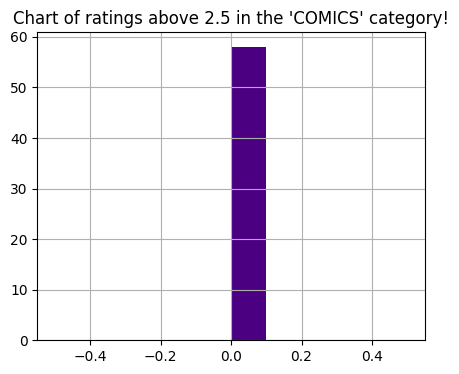

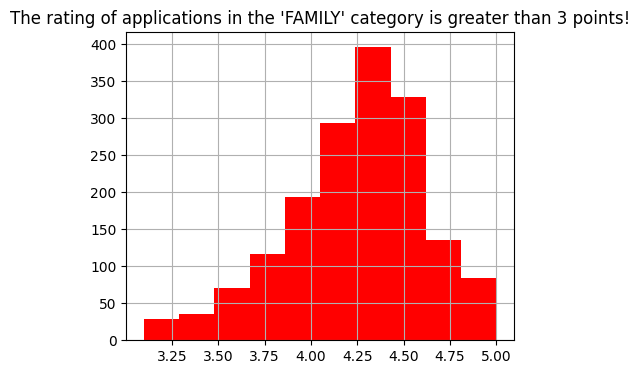

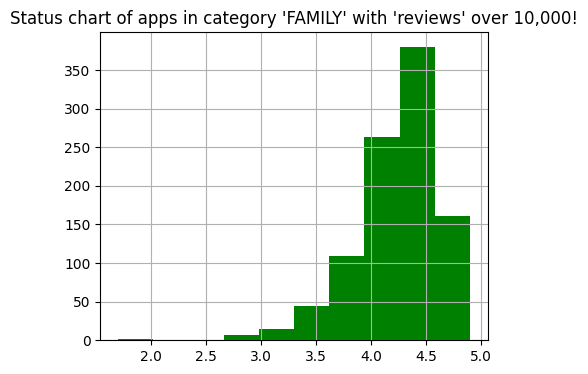

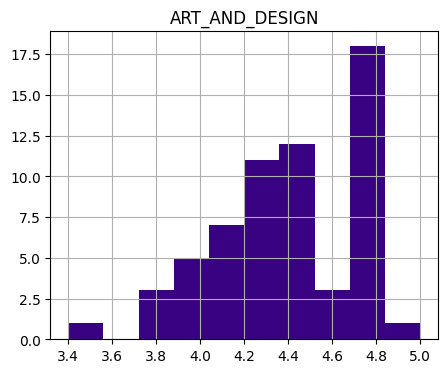

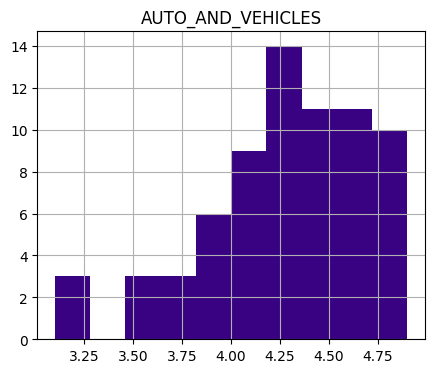

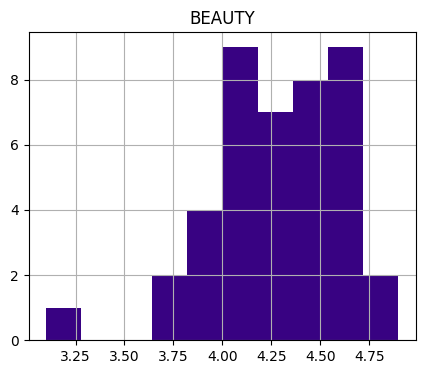

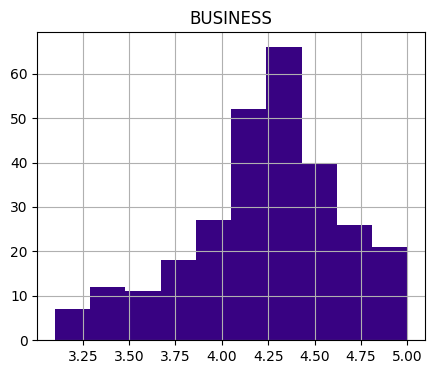

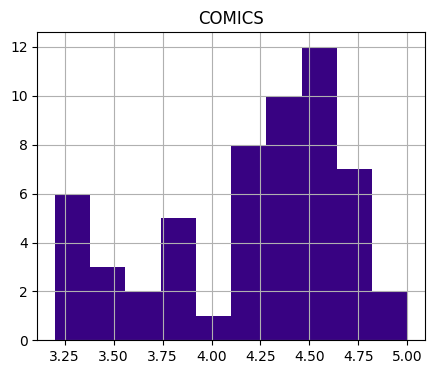

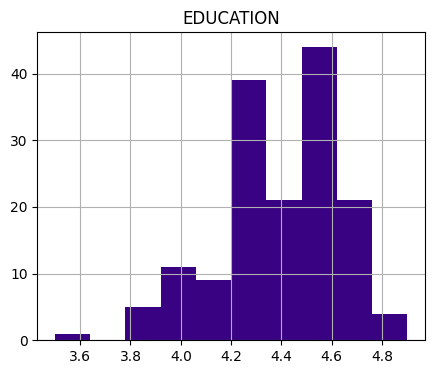

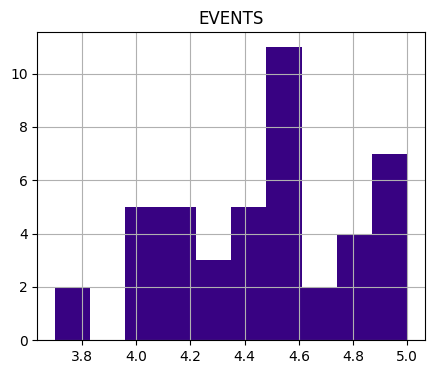

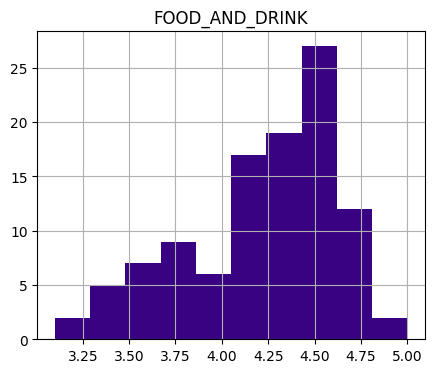

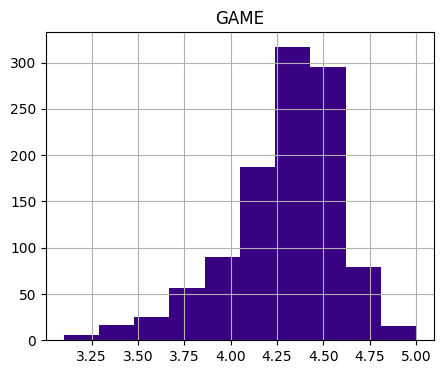

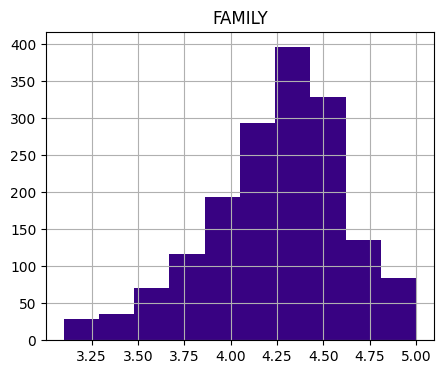

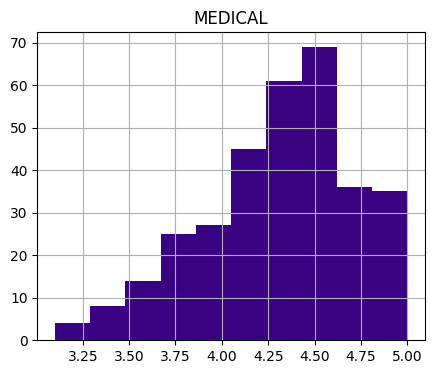

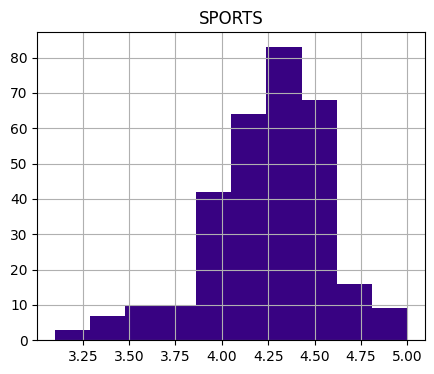

In [22]:
def print_histograms(dataset):
    ##Tables of the main results of applications in the "FAMILY" category.
    rating_COMICS = dataset[(dataset.Category == "COMICS") & (dataset.Rating > 2.5)]
    rating_COMICS.set_index("App")["Price"].hist(color='indigo',figsize=[5,4])
    plt.title("Chart of ratings above 2.5 in the 'COMICS' category!")
    plt.show()


    rate = dataset[(dataset.Category == "FAMILY")& (dataset.Rating > 3)]
    rate.set_index("App")["Rating"].hist(color='red',figsize=[5,4])
    plt.title("The rating of applications in the 'FAMILY' category is greater than 3 points!")
    plt.show()

    reviews = dataset[(dataset.Category == "FAMILY")&(dataset.Reviews > 1000)]
    reviews.set_index("App")["Rating"].hist(color='green',figsize=[5,4])
    plt.title("Status chart of apps in category 'FAMILY' with 'reviews' over 10,000!")
    plt.show()

    ######################################
    ART_AND_DESIGN = dataset[(dataset.Category == "ART_AND_DESIGN")& (dataset.Rating > 3)]
    ART_AND_DESIGN.set_index("App")["Rating"].hist(color='xkcd:indigo',figsize=[5,4])
    plt.title("ART_AND_DESIGN")
    plt.show()

    AUTO_AND_VEHICLES = dataset[(dataset.Category == "AUTO_AND_VEHICLES")& (dataset.Rating > 3)]
    AUTO_AND_VEHICLES.set_index("App")["Rating"].hist(color='xkcd:indigo',figsize=[5,4])
    plt.title("AUTO_AND_VEHICLES")
    plt.show()

    BEAUTY = dataset[(dataset.Category == "BEAUTY")& (dataset.Rating > 3)]
    BEAUTY.set_index("App")["Rating"].hist(color='xkcd:indigo',figsize=[5,4])
    plt.title("BEAUTY")
    plt.show()

    BUSINESS = dataset[(dataset.Category == "BUSINESS")& (dataset.Rating > 3)]
    BUSINESS.set_index("App")["Rating"].hist(color='xkcd:indigo',figsize=[5,4])
    plt.title("BUSINESS")
    plt.show()

    COMICS = dataset[(dataset.Category == "COMICS")& (dataset.Rating > 3)]
    COMICS.set_index("App")["Rating"].hist(color='xkcd:indigo',figsize=[5,4])
    plt.title("COMICS")
    plt.show()

    EDUCATION = dataset[(dataset.Category == "EDUCATION")& (dataset.Rating > 3)]
    EDUCATION.set_index("App")["Rating"].hist(color='xkcd:indigo',figsize=[5,4])
    plt.title("EDUCATION")
    plt.show()

    EVENTS = dataset[(dataset.Category == "EVENTS")& (dataset.Rating > 3)]
    EVENTS.set_index("App")["Rating"].hist(color='xkcd:indigo',figsize=[5,4])
    plt.title("EVENTS")
    plt.show()

    FOOD_AND_DRINK = dataset[(dataset.Category == "FOOD_AND_DRINK")& (dataset.Rating > 3)]
    FOOD_AND_DRINK.set_index("App")["Rating"].hist(color='xkcd:indigo',figsize=[5,4])
    plt.title("FOOD_AND_DRINK")
    plt.show()

    GAME = dataset[(dataset.Category == "GAME")& (dataset.Rating > 3)]
    GAME.set_index("App")["Rating"].hist(color='xkcd:indigo',figsize=[5,4])
    plt.title("GAME")
    plt.show()

    FAMILY = dataset[(dataset.Category == "FAMILY")& (dataset.Rating > 3)]
    FAMILY.set_index("App")["Rating"].hist(color='xkcd:indigo',figsize=[5,4])
    plt.title("FAMILY")
    plt.show()

    MEDICAL = dataset[(dataset.Category == "MEDICAL")& (dataset.Rating > 3)]
    MEDICAL.set_index("App")["Rating"].hist(color='xkcd:indigo',figsize=[5,4])
    plt.title("MEDICAL")
    plt.show()

    SPORTS = dataset[(dataset.Category == "SPORTS")& (dataset.Rating > 3)]
    SPORTS.set_index("App")["Rating"].hist(color='xkcd:indigo',figsize=[5,4])
    plt.title("SPORTS")
    plt.show()
histogram = print_histograms(clean_data)
histogram

In [23]:
price = clean_data[(clean_data.Category == "COMICS") & (clean_data.Rating > 2.5)]
price.set_index("App")["Price"]
price


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
297,LINE WEBTOON - Free Comics,COMICS,4.5,1013635,NaN,10000000,Free,0.0,Teen,Comics,2018-07-31,NaN,Varies with device
298,Manga Master - Best manga & comic reader,COMICS,4.6,24005,0.0049,500000,Free,0.0,Adults only,Comics,2018-07-04,1.1.7.0,4.1 and up
299,GANMA! - All original stories free of charge f...,COMICS,4.7,57106,0.0270,1000000,Free,0.0,Teen,Comics,2018-07-23,2.11.3,4.1 and up
300,Röhrich Werner Soundboard,COMICS,4.7,2249,0.0320,500000,Free,0.0,Everyone,Comics,2017-11-16,1.08,4.0.3 and up
301,Unicorn Pokez - Color By Number,COMICS,4.8,516,0.0120,50000,Free,0.0,Everyone,Comics;Creativity,2018-08-03,1.0.6,4.4 and up
302,MangaToon - Comics updated Daily,COMICS,3.9,834,0.0150,50000,Free,0.0,Mature,Comics,2018-08-01,1.0.8,4.1 and up
303,Manga Net – Best Online Manga Reader,COMICS,4.1,1010,0.0110,50000,Free,0.0,Mature,Comics,2018-07-07,1.5,4.1 and up
304,Manga Rock - Best Manga Reader,COMICS,4.4,238970,0.0280,1000000,Free,0.0,Teen,Comics,2018-07-09,3.4.3_world,5.0 and up
305,Manga - read Thai translation,COMICS,4.6,302,0.0022,10000,Free,0.0,Teen,Comics,2018-07-03,1.0,4.0 and up
306,The Vietnam Story - Fun Stories,COMICS,4.5,438,0.0034,10000,Free,0.0,Everyone,Comics,2017-12-27,1.0,2.3 and up


In [24]:
def compute_correlations_matrix(dataset):
    return dataset.select_dtypes(include=np.numberx).corr(); # select_dtypes()

cr = compute_correlations_matrix(clean_data)
cr

,Rating,Reviews,Size,Installs,Price
Rating,1.000000,0.068133,-0.018903,0.051337,-0.021919
Reviews,0.068133,1.000000,0.036540,0.641605,-0.009824
Size,-0.018903,0.036540,1.000000,0.016522,0.018480
Installs,0.051337,0.641605,0.016522,1.000000,-0.011895
Price,-0.021919,-0.009824,0.018480,-0.011895,1.000000


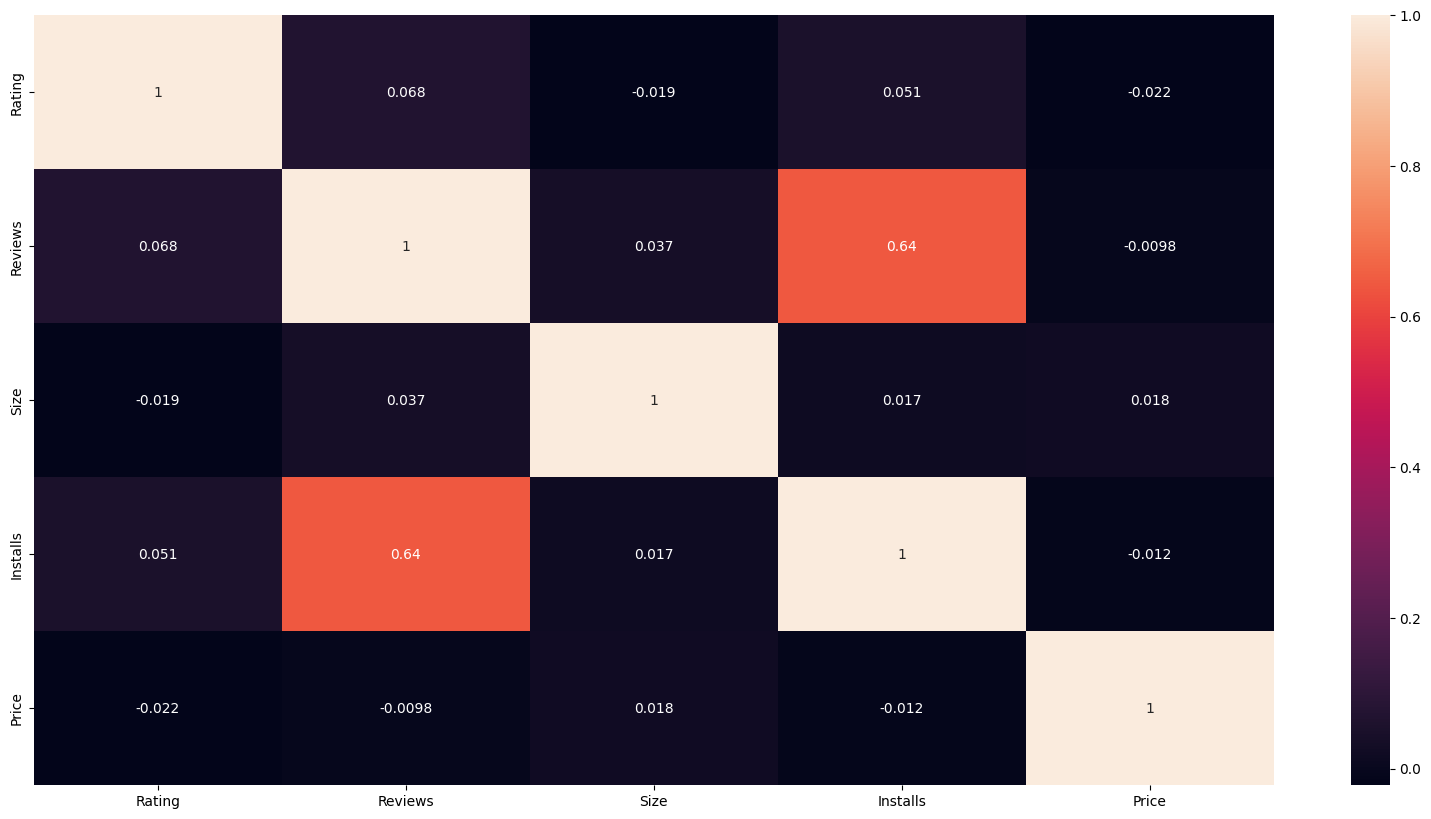

In [25]:
plt.figure(figsize=(20,10))
sns.heatmap(cr, annot = True)
plt.show()

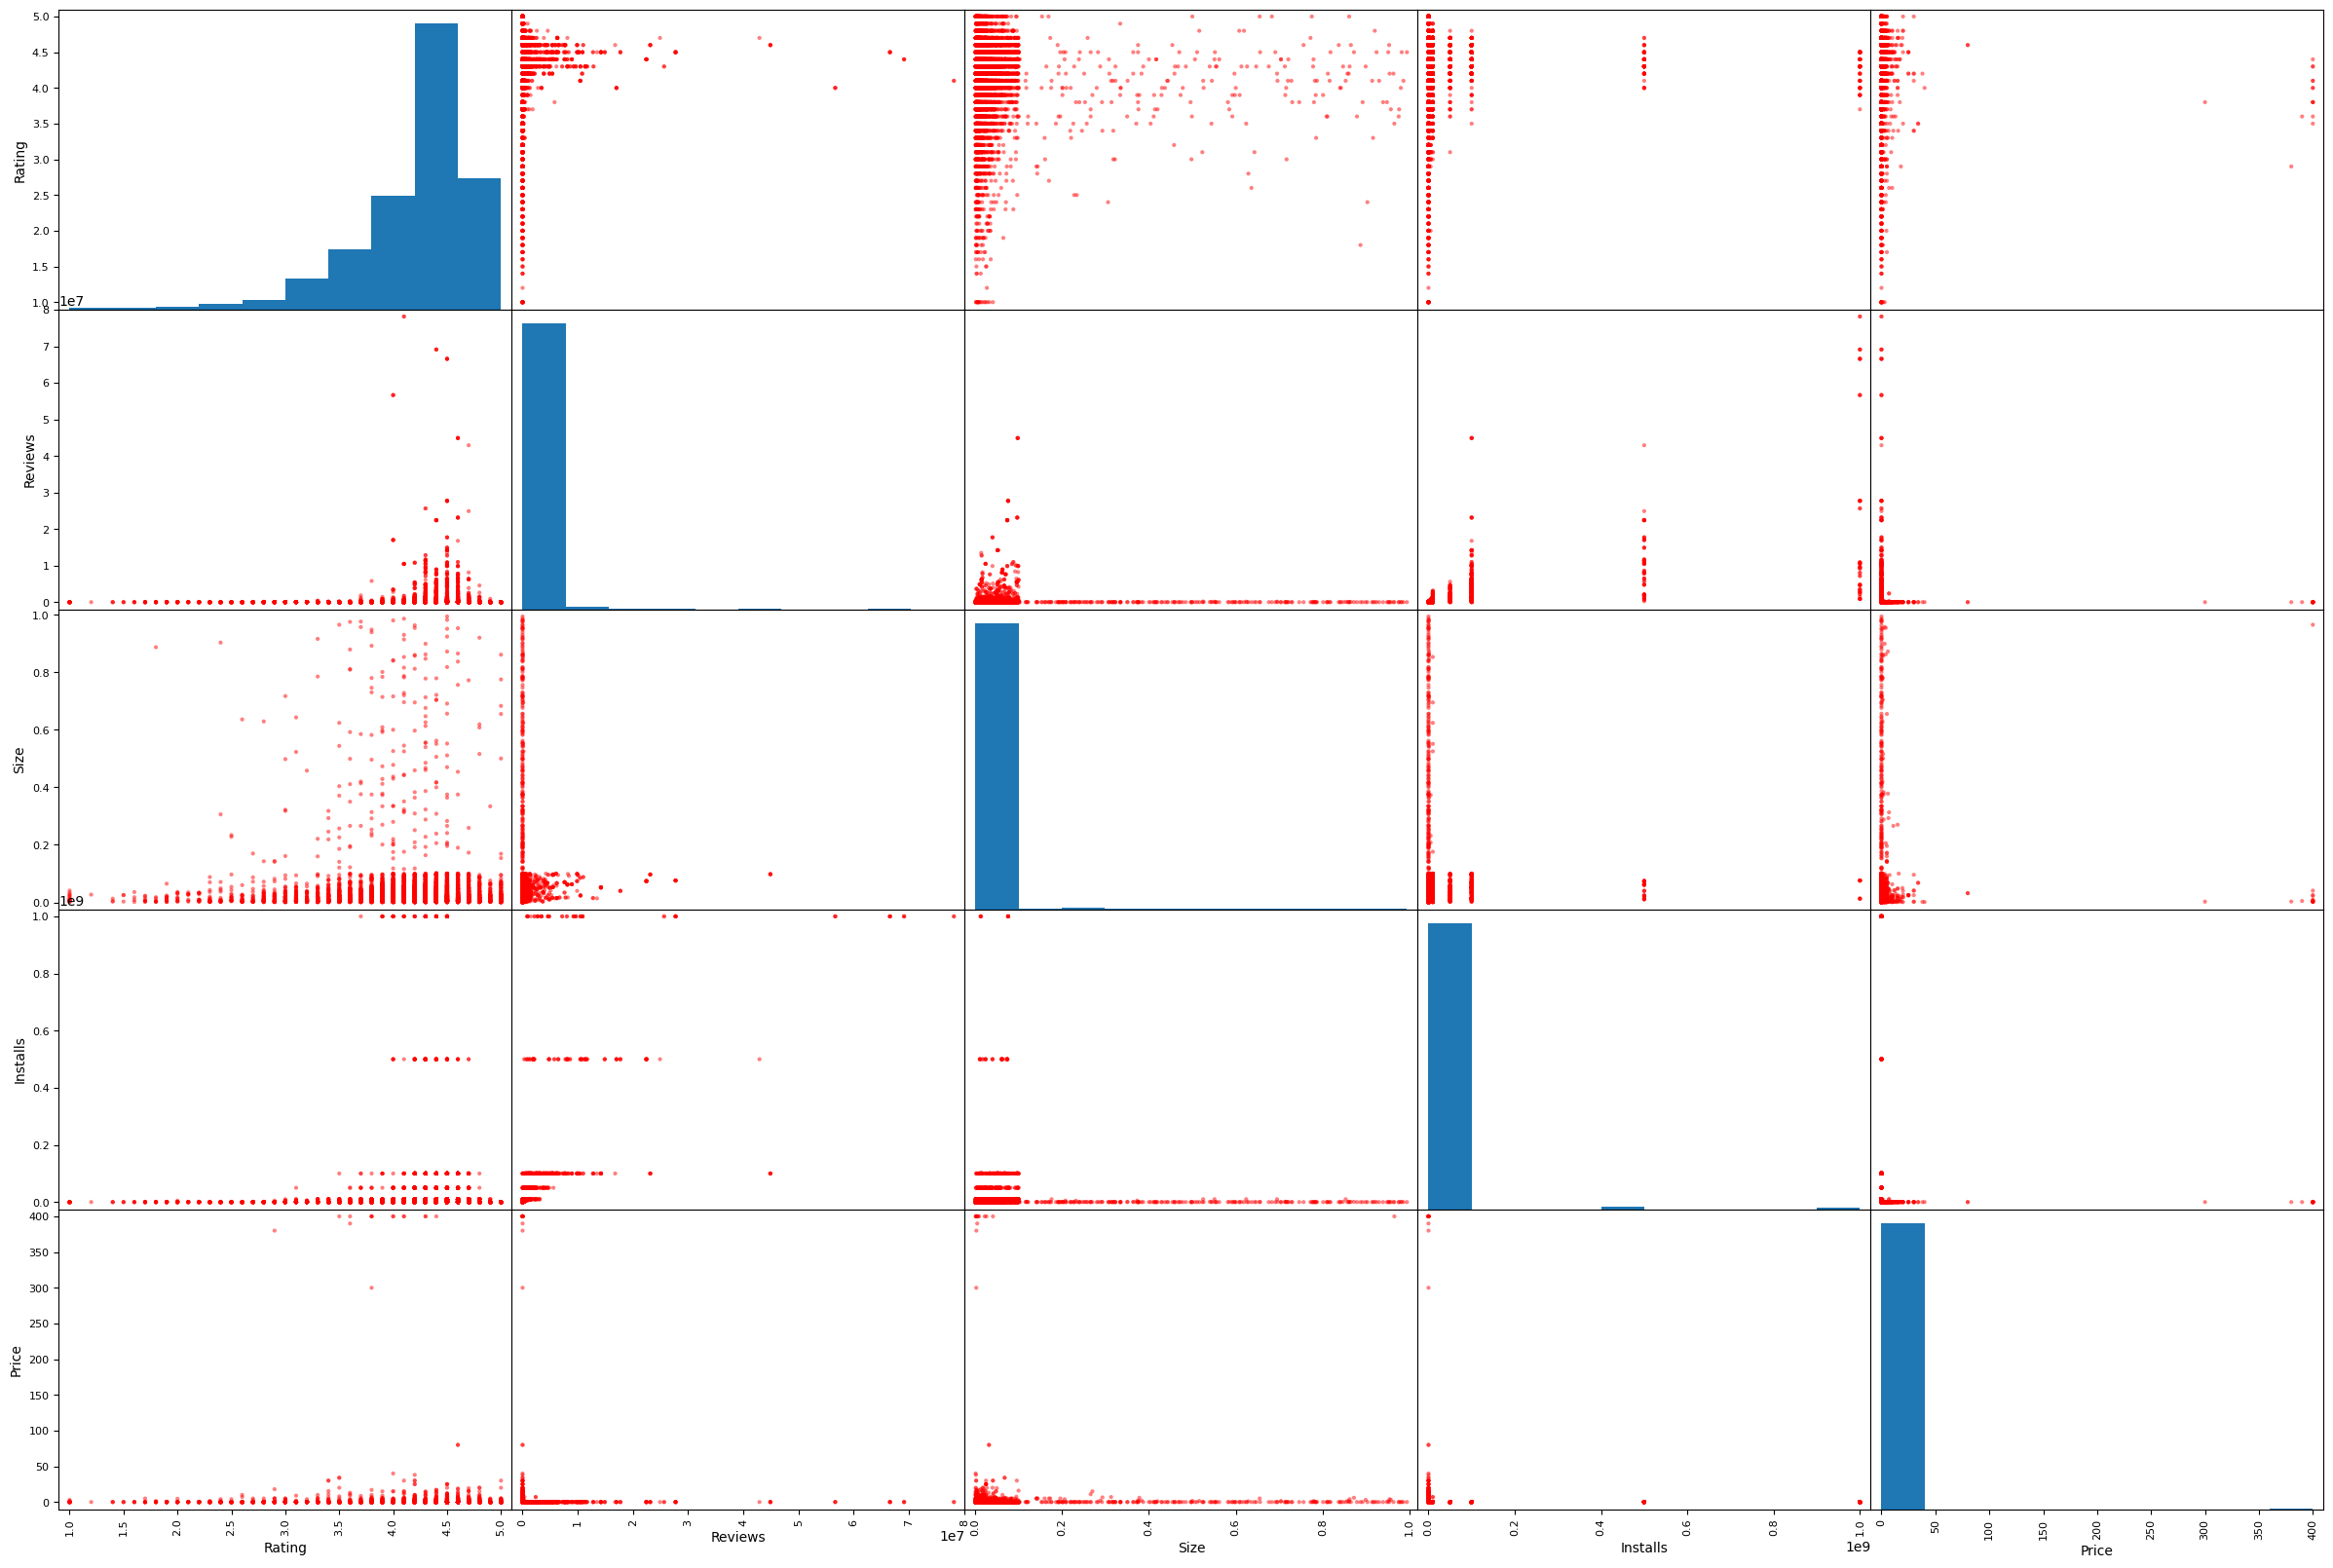

In [27]:
def print_scatter_matrix():
    pd.plotting.scatter_matrix(clean_data,alpha=0.5,figsize=(30,20), color="red")
    plt.show()
s=print_scatter_matrix()
s

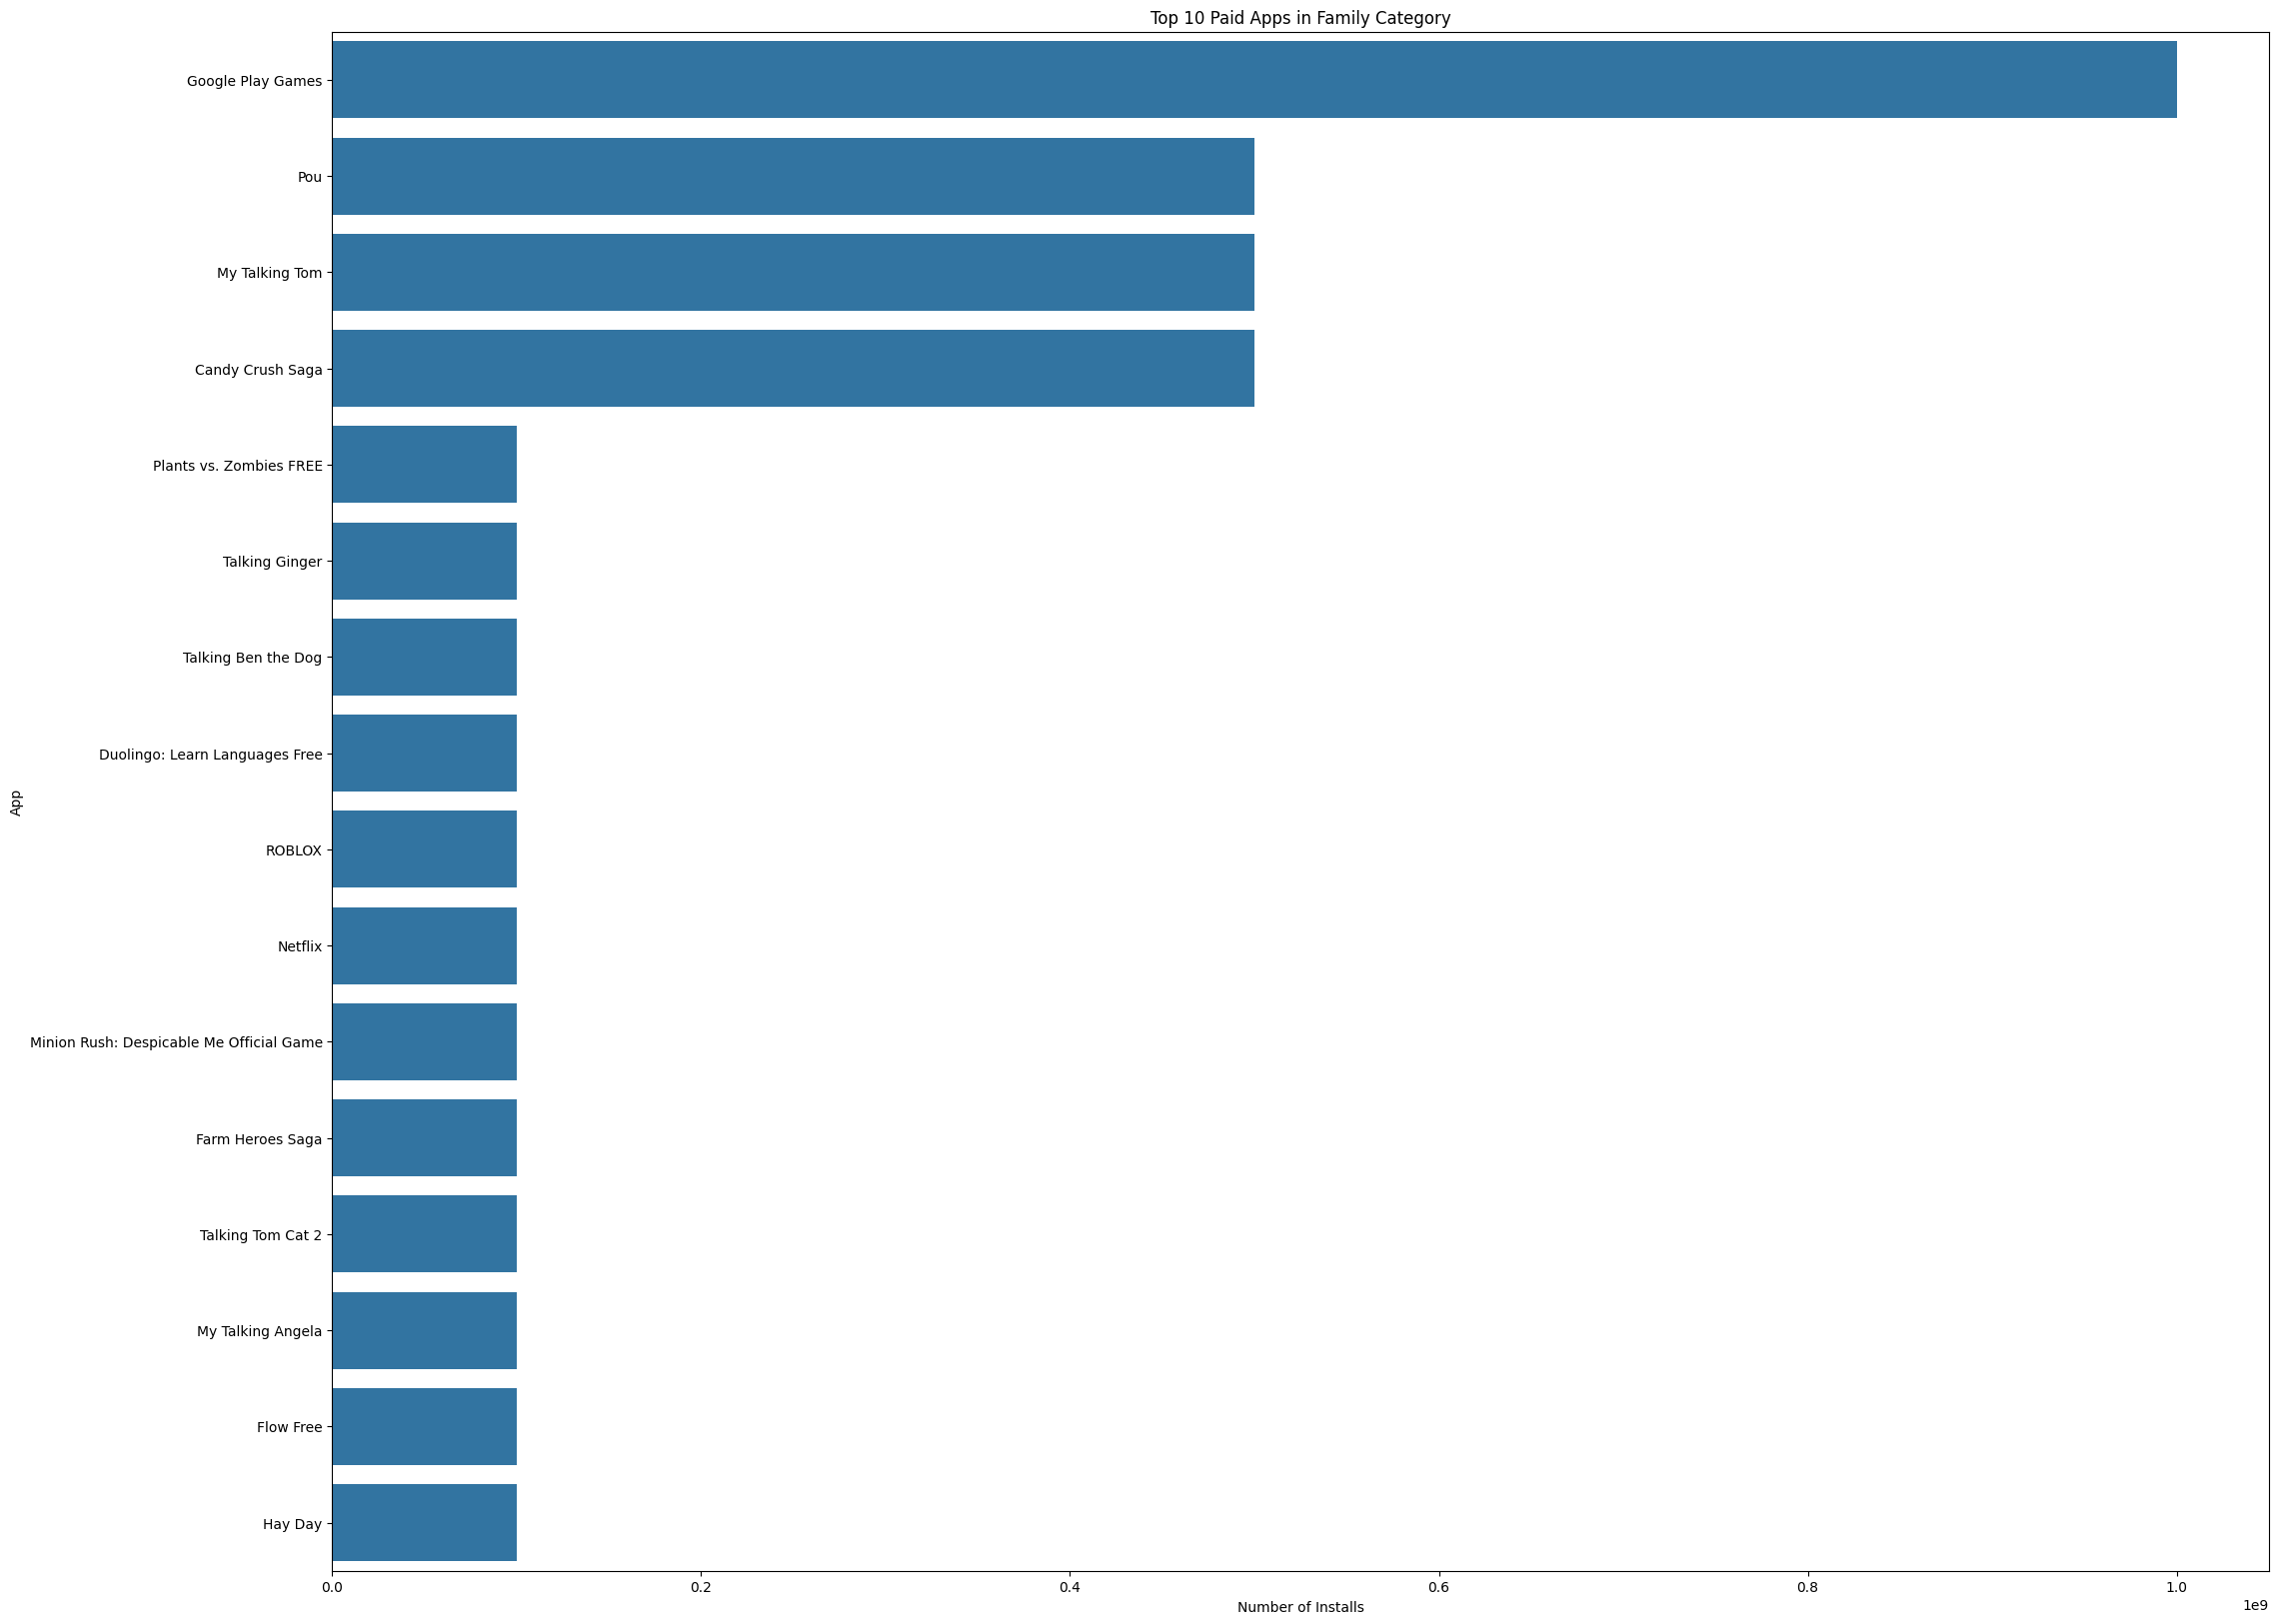

In [28]:
def paid_apps(dataset):
    family = clean_data[(clean_data['Category'] == 'FAMILY') & (clean_data['Type'] == 'Free')]
    family = family.sort_values('Installs', ascending = False).head(20)

    plt.figure(figsize = (25, 20))
    plt.title("Top 10 Paid Apps in Family Category")
    sns.barplot(data = pd.DataFrame({'App' : family['App'], 'Number of Installs' : family['Installs']}), y='App', x = 'Number of Installs')

    plt.show()
p_a=paid_apps(clean_data)
p_a

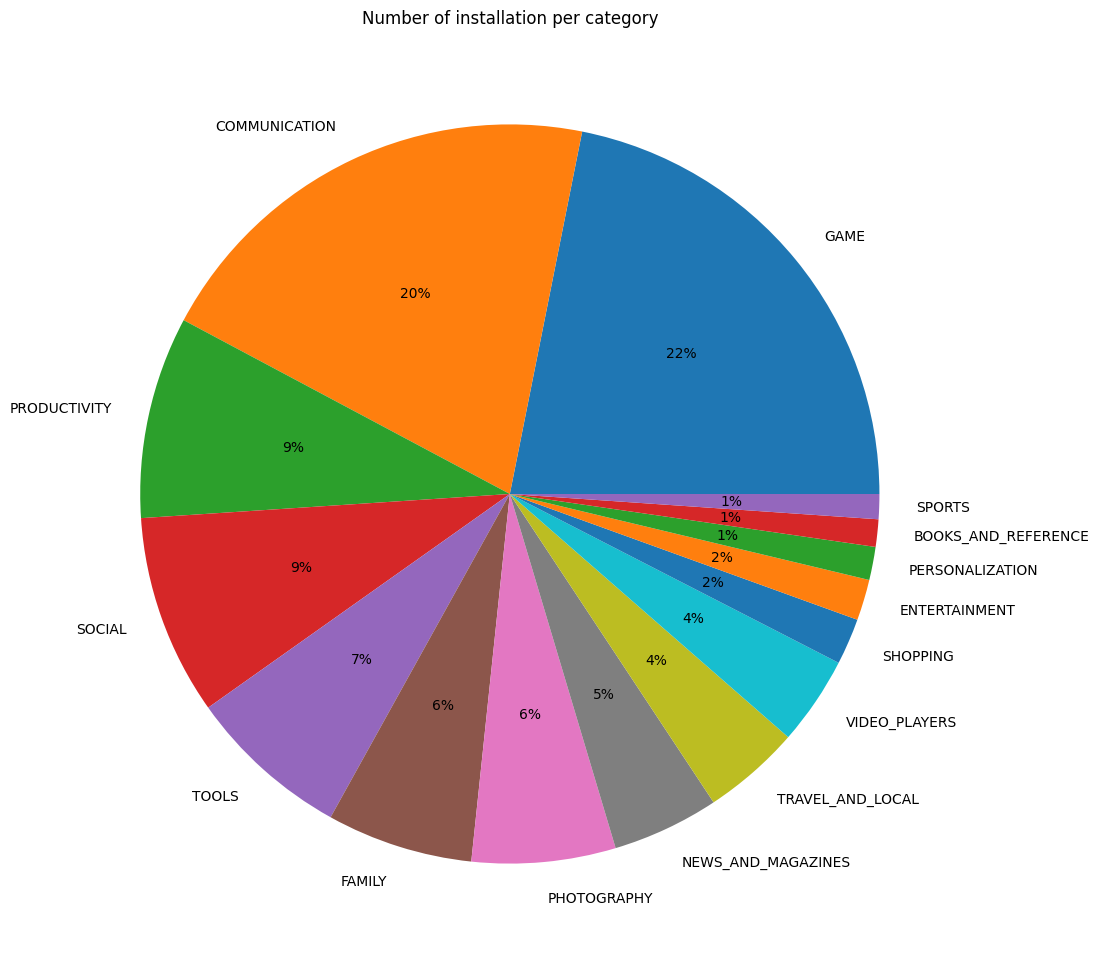

In [29]:
def pie_installs(dataset):
    categories = dataset['Category'].unique()

    count = []
    for categori in categories:
        count.append(dataset[dataset['Category'] == categori]['Installs'].sum())

    count = pd.DataFrame({'Category' : categories, 'Count' : count})
    count.sort_values('Count', ascending = False, inplace=True)
    count = count.head(15)

    plt.figure(figsize = (12, 12))
    plt.title("Number of installation per category")

    color = sns.color_palette()
    plt.pie(count['Count'], labels = count['Category'], autopct='%.0f%%', colors = color)

    plt.show()

pie_installs(clean_data)

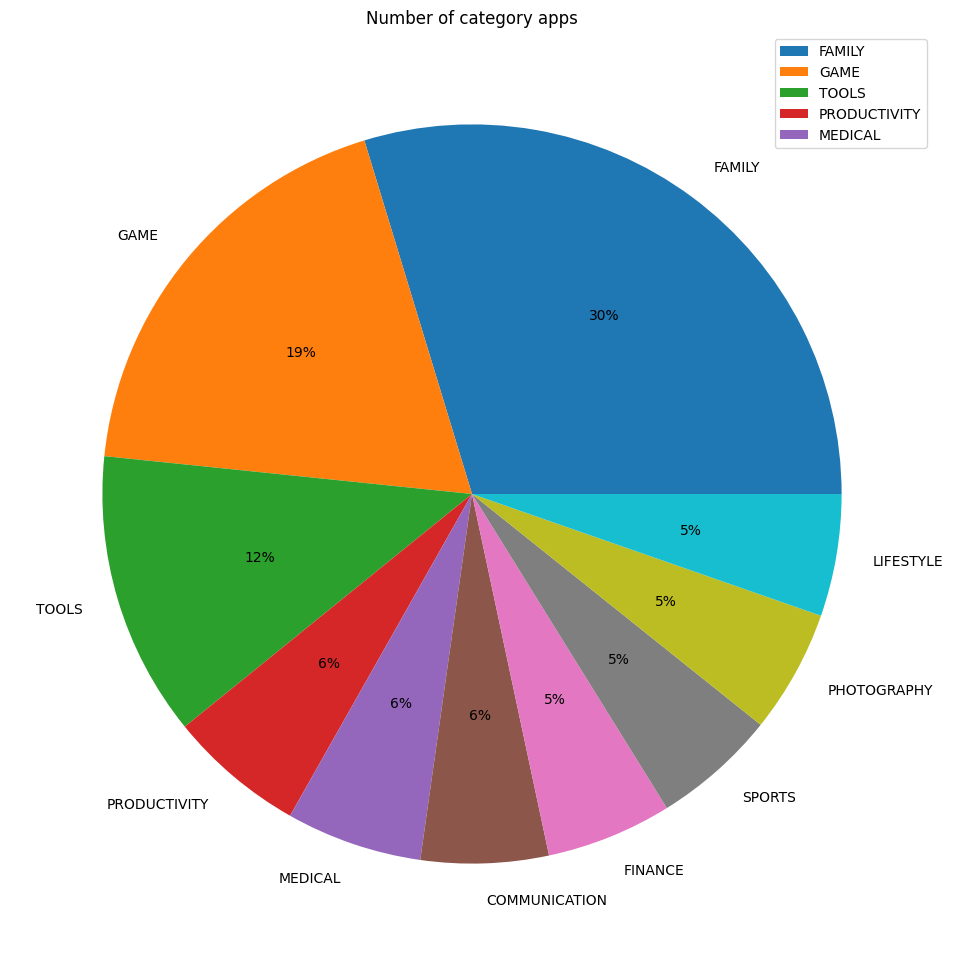

In [30]:
def pie_category_apps(dataset):
    count = dataset['Category'].value_counts()
    count.sort_values(ascending = False, inplace = True)

    count = dataset['Category'].value_counts()
    plt.figure(figsize = (12, 12))

    colors = sns.color_palette()
    plt.pie(count.values[:10], labels = count.index[:10], autopct='%.0f%%', colors = colors)
    plt.title("Number of category apps")
    plt.legend(count.index[:5])
    plt.show()

pie_category_apps(clean_data)

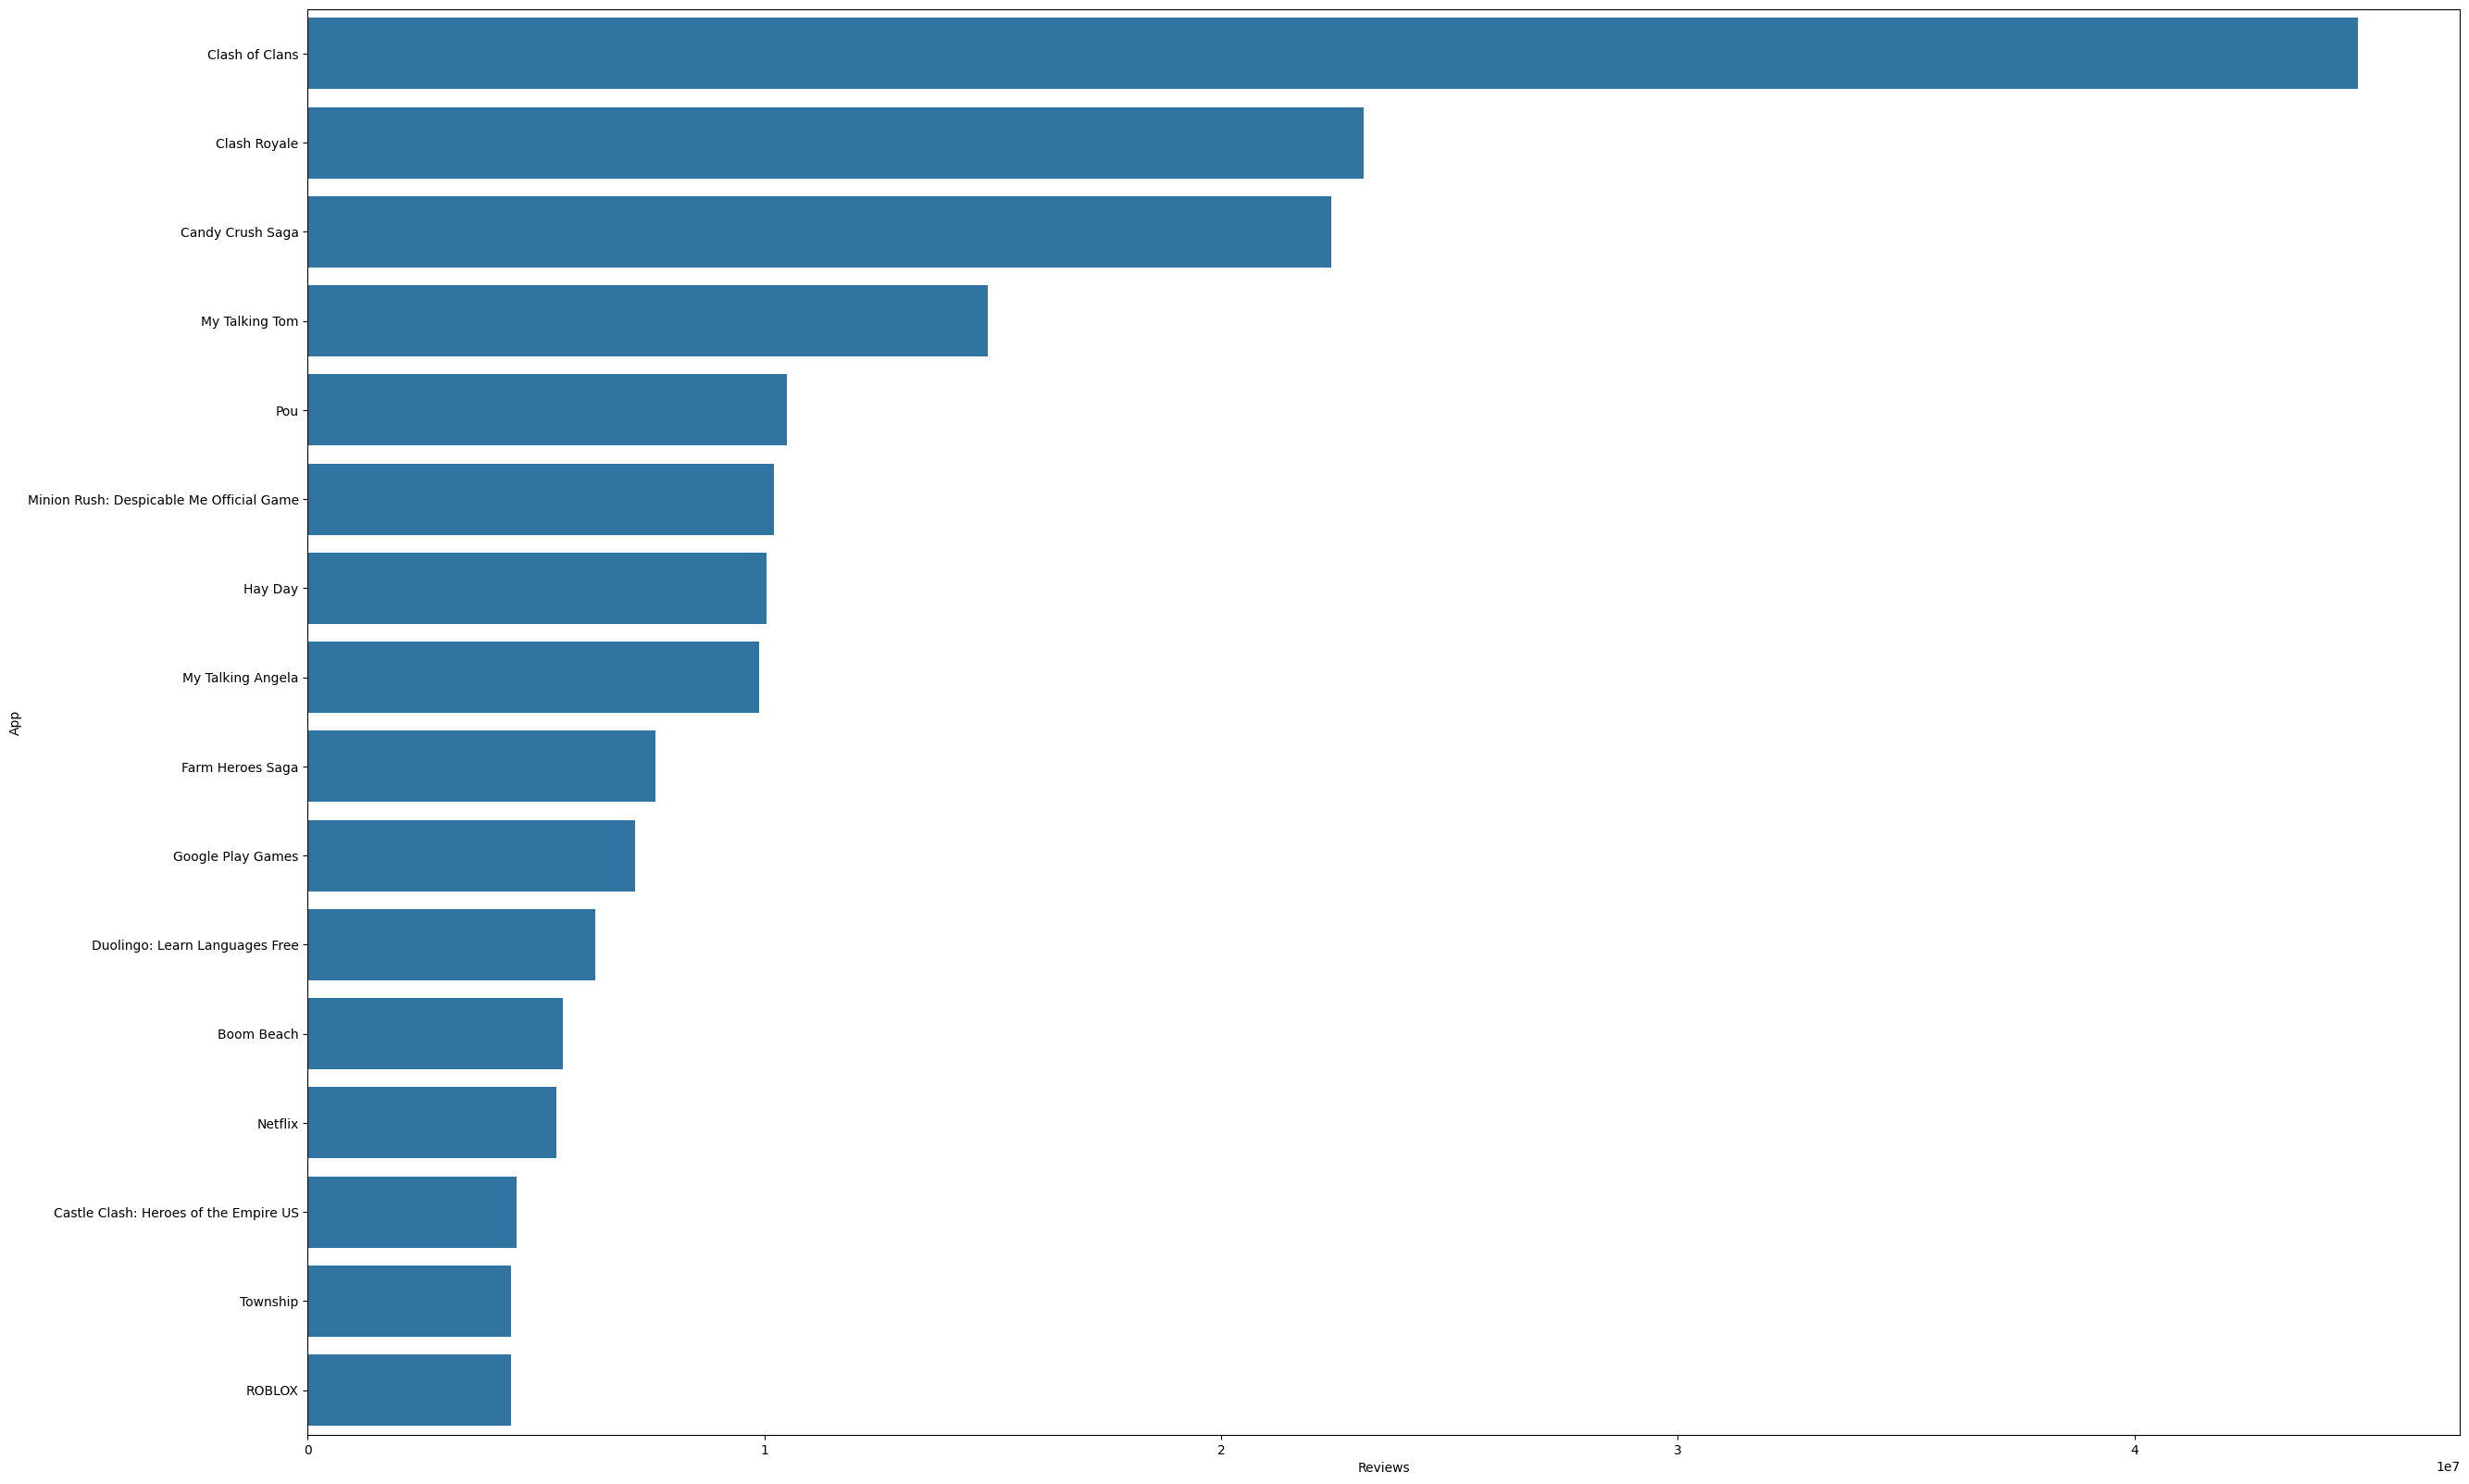

In [31]:
def family_apps_ratings(dataset):
    social = clean_data[(clean_data['Category'] == 'FAMILY')].sort_values(['Reviews', 'Installs', 'Rating'], ascending = False).head(20)

    plt.figure(figsize=(30, 20))
    sns.barplot(data = social, x = 'Reviews' , y = 'App')

    plt.show()
family_apps_ratings(clean_data)

In [16]:
#Thank you.Go to the my blog post